# Smoking Analysis 🚬

## Domain Expertise 👨‍⚕️

There are quite a few variables that have high correlations with one another and may not initially be of great value as it pertains to smoking predictions. As such, it is worth doing some layman's research about each of the variables and how they are known to relate to eachother in the real world.

### Age 👶

The ```Age``` is given in a 5-year gap form, which is why we can see it is binnend rounded to the nearest 5 years for individuals.

The dataset was released in December of 2022, so it is fiarly new/up-to-date. In western countries, age tends to follow a u-shaped curve: younger folks smoke more, middle-aged smoke less, and older folks smoke more as well. As people grow older, they are likely to quit smoking - often due to a number of factors like health issues (sometimes directly experienced), family responsibilities or societal changes. Age is seen to have cohort effects (binning with generations) since it is peer influenced.

### Height 📏

Generally ```height``` is considered a weak variable since it has a limited direct relationship. ```Smoking``` CAN result in delayed growth due to hormonal inefficiencies, and poor nutrition from bad eating. The value of the variable is quite questionable however.

### Weight 𐄷

```Smoking``` can lead to appetite suppression, which can result in lower weight. It can also result in metabolic rate increasing and more calories being burned (therefore also lower weight). Often quitters will see weight gain after quitting. This is interesting because it directly conflicts with the data we are seeing here. It may be extremely worth examining ```BMI``` since it is quite possible that this sample simply has a lot of tall smokers. It would be interesting to find out if this survey was taken from the Netherlands or something.

### Waist 📏

```Waist size``` was seen as one of the top 10 parameters within most of the models. It exibits a high correlation with ```weight``` which is noteworthy. ```Smoking``` is seen to have been associated with changes in body fat distribution - more fat accumulating around the abdomen is seen to be correlated with smoking (leading to an increase in waist circumference). Smoking also can lead to an increase in visceral fat (fat stored around abdominal organs) which can increase waist size.

### Eyesight 👁️

```Smoking``` is a well-established risk factor for AMD (age-related macular degeneration). ```AMD``` is a leading cause for vision loss among older adults. It can also result in an increased risk of developing cataracts. It can result in diabetic retinopathy, which damages eyesight for individuals with diabetes. There is SOME data indicating reduced night vision. So this variable is fairly important, and it is surprising we are seeing it towards the bottom of the importance list. 

It is worth noting that with things like ```AMD``` and ```Cataracts```, which affect only a single eye and which are generally correlated with smoking it is likely of higher value to keep these variables separate.

### Hearing 👂

Hearing has been generally ranked as one of the lowest-valued variables, which shouldn't necessarily be the case. Less blood and less oxygen reach the ears with smokers (resulting in poor hearing). There is also an increased risk of ```Tinnitus```, the perceived ringing of the ears (with no real sounds). There is also an acceleration of age-related hearing loss with smokers.

It is worth noting, that unlike with ```eyesight```, smoking tends to correlate with earing bilaterally. Therefore it may be worth setting this up as a categorical variables (e.g. [bad_hearing, good_hearing, damaged_ear] or [bad_hearing, good_hearing])

### Systolic

```Systolic blood pressure``` is specifically the pressure in the arteries when the blood contracts and pumps.

The ```Systolic blood pressure``` ranked mid-high on the variable importances for smoking correlation. Smoking can result in higher systolic blood pressure. When nicotine is immediately in the blood stream (short term), systolic blood pressure can rise. Long-term smoking can contribute to chronic high-blood-pressure (hypertension). It can also worsen existing hypertension and interfere with medications that exist to assuage high blood pressure. This dataset does not have diastolic blood pressure.

### Relaxing Heart Rate 🫀

```Relaxed``` heart rate can be elevated by smoking in several manners. Nicotine in the bloodstream can temporarily increase heart rate. ```Smoking``` can lead to persistent changes in the cardiovascular system that lead to chronic heart rate elevation. It can decrease cardiovascular efficiency and fitness levels, leading for the heart to need to do more work when an individual is relaxed.

The ```Relaxed``` heart rate had a very high correlation with the ```Systolic``` blood pressure, but was not seen as quite as an important variable as ```Systolic``` blood pressure.

### Fasting Blood Sugar 🩸

```Fasting Blood Sugar``` ranked among the higher of variable importances in machine learning models, and is unique in that it didn't correlate too strongly with many other variables (aside from ```Relaxing Heart Rate```). Smoking can elevate ```Fasting Blood Sugar``` by increasing insulin resistance, reducing cardiovascular capabilities, and damaging pancriatic functionality that allows the body to process blood sugar. As such, one would certainly anticipate this variable to be very valuable when predicting whether an individual smokes.

### Cholesterol 🧈

The ```total cholesterol``` ranks the 3rd most important feature when predicting smoking in baseline models, with the ```HDL``` and ```LDL``` levels being of similar importance. Certainly there are very high correlations between the ```total cholesterol``` and ```LDL``` (but less so with ```HDL``` levels).

Smoking seems to largely affect the specific cholesterol levels differently. It can **increase** ```LDL``` cholesterol ("bad cholesterol") and **reduce** ```HDL``` cholesterol ("good cholesterol").

## Initial Configuration ⚙️

In [1384]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# XGBoost - may not need them all
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

#### Global Variables

In [1385]:
random_seed = 42

# Target variable is smoking
target = 'smoking'

# Assume that the kaggle files for the competition are locate`d in the current directory
sample_submission_filepath = './sample_submission.csv'
testing_filepath = './test.csv'
training_filepath = './train.csv'

# Break if we don't have the files
assert(os.path.exists(sample_submission_filepath) and os.path.exists(testing_filepath) and os.path.exists(training_filepath))

#### Helper Functions

In [1386]:
"""Helper function to show a simple pie chart of a categorical variable for distribution analysis"""
def do_pie(df, col, title=""):
    if col not in df.columns:
        print("Error, column specified is not in the dataframe's columns")
        return
    val_counts = df[col].value_counts()
    plt.pie(val_counts, labels=val_counts.keys(), autopct='%1.1f%%')
    if title == "":
        title = "Distribution of " + col
    plt.title(title)
    plt.show()

"""Helper function to plot side-by-side pie charts for the different survival rates for differing values in a column
  NOTE: the otherCol needs to be a boolean column with value counts else this function will likely break"""
def plot_target_representation(df, col, otherCol=target):
    grouped = df.groupby([col, otherCol]).size().unstack().fillna(0)
    value_counts = df[col].value_counts()
    target_labels = df[otherCol].value_counts().keys().sort_values()
    fig, axes = plt.subplots(1, len(value_counts.keys()), figsize=(16,6))
    for idx, key in enumerate(value_counts.keys()):
        axes[idx].pie(grouped.loc[key], labels=target_labels, autopct='%1.1f%%', startangle=90)
        axes[idx].set_title(col + " " + str(key))
    plt.tight_layout()
    plt.show()

### Load in the Data

The below cell loads the training, testing and sample submission dataframes, ensuring the flow of execution cannot continue if any of them are empty.

We are able to see that the training data has 150k entries and 24 columns

In [1387]:
df = pd.read_csv(training_filepath)
df_test = pd.read_csv(testing_filepath)
df_sample_submission = pd.read_csv(sample_submission_filepath)

assert(df.shape[0] > 0 and df.shape[1] > 0 and df_test.shape[0] > 0 and df_test.shape[1] > 0 and df_sample_submission.shape[0] > 0 and df_sample_submission.shape[1] > 0)
df.shape

(159256, 24)

## EDA 🔍

### General Data Examination 🔍

By getting the info of the dataframe we are able to see that it doesn't appear any of the columns have null entries.
At first glance, most variables seem to be continuous, but it is possible there are some categorical values as well.

In [1388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

#### Null Values

We are able to see that there are **no** null values to be dealt with, which is quite nice. The below snippet will break if this is not the case.

In [1389]:
total_null_values = 0
for key in df.isna().sum().keys():
    total_null_values = total_null_values + df.isna().sum()[key]
assert(total_null_values == 0)

#### Duplicate Values

There are no duplicated values to be dealt with. The original dataset actually did have many duplicated values, so it's nice the kaggle competition removed them from necessity in preprocessing. The below snippet will break the flow of execution if there ARE any duplicate values.

In [1390]:
assert(df.duplicated().sum() == 0)

From describing the dataframe we are able to glean some insights.
* Looks like ```id``` is more or less just indexed for each row. It will be removed for machine learning.
* ```age``` has a mean of **44** indicating slightly older adults with the youngest aged at **20** and the oldest aged at **85**.
* ```height``` seems normally distributed.
* ```weight``` seems normally distributed.

In [1391]:
df.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


The target variable of ```smoking``` seems relatively-evenly distributed with only **6.3%** more of the entire population being non-smoking, but this shouldn't require any resampling measures to be taken.

### Target Variable Examination 🎯

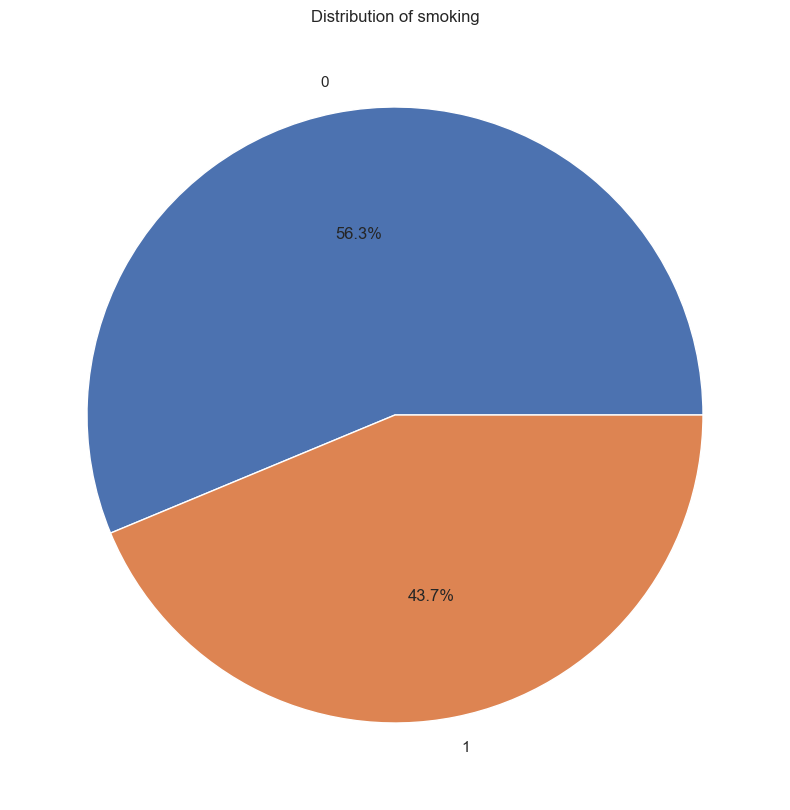

In [1392]:
do_pie(df, target)

### Categorical Variable Examination 📊

Assuming each categorical variable should have no more than **10** unique values, we are able to see the categorical variables outputted in the cell below:

In [1393]:
categorical_variables = []
numerical_variables = []

for col in df.columns:
    if len(df[col].value_counts().keys()) < 10:
        categorical_variables.append(col)
    else:
        numerical_variables.append(col)

categorical_variables

['hearing(left)',
 'hearing(right)',
 'Urine protein',
 'dental caries',
 'smoking']

Since categorical variables may be directly used in cleaning and machine learning, we want to remove the target so it doesn't get treated like a feature.

In [1394]:
if target in categorical_variables:
    categorical_variables.remove(target)

assert(target not in categorical_variables)

We are able to see the list of nuerical variables outputted below.

In [1395]:
for idx, var in enumerate(numerical_variables):
    print(var, end=", ")
    if (idx+1) % 8 == 0:
        print()

id, age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), systolic, 
relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, serum creatinine, 
AST, ALT, Gtp, 

In [1396]:
# Helper function to plot side-by-side pie charts for the different survival rates for differing values in a column
#   NOTE: the otherCol needs to be a boolean column with value counts else this function will likely break
def plot_target_representation(df, col, otherCol=target):
    grouped = df.groupby([col, otherCol]).size().unstack().fillna(0)
    value_counts = df[col].value_counts()
    target_labels = df[otherCol].value_counts().keys().sort_values()
    fig, axes = plt.subplots(1, len(value_counts.keys()), figsize=(16,6))
    for idx, key in enumerate(value_counts.keys()):
        axes[idx].pie(grouped.loc[key], labels=target_labels, autopct='%1.1f%%', startangle=90)
        axes[idx].set_title(col + " " + str(key))
    plt.tight_layout()
    plt.show()

#### Plotting the Categorical Variable Distributions

From plotting the distributions of the categorical variables, we are able to make some observations about the underlying dataset:
* Only around **2.3%** of the general population had hearing issues (in either ear)
* **94.7%** of the population has ```urine protein``` **1**. The rest of the versions are extremely imbalanced.
* ```dental carries``` has the cleanest distribution of any of the categorical variables, with **20%** on the minority variable, which is only classified as a slight imbalance.

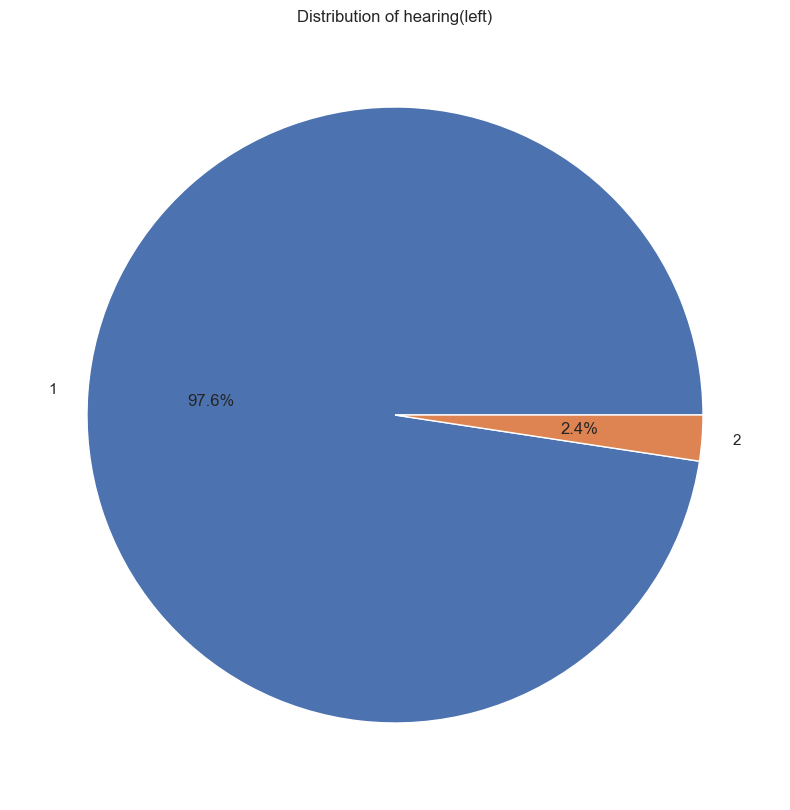

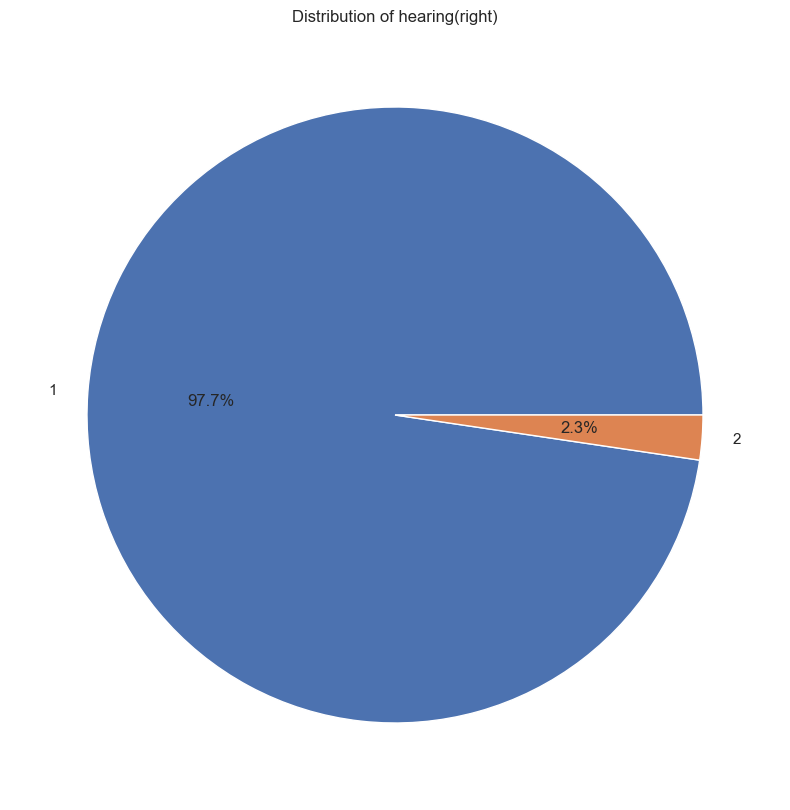

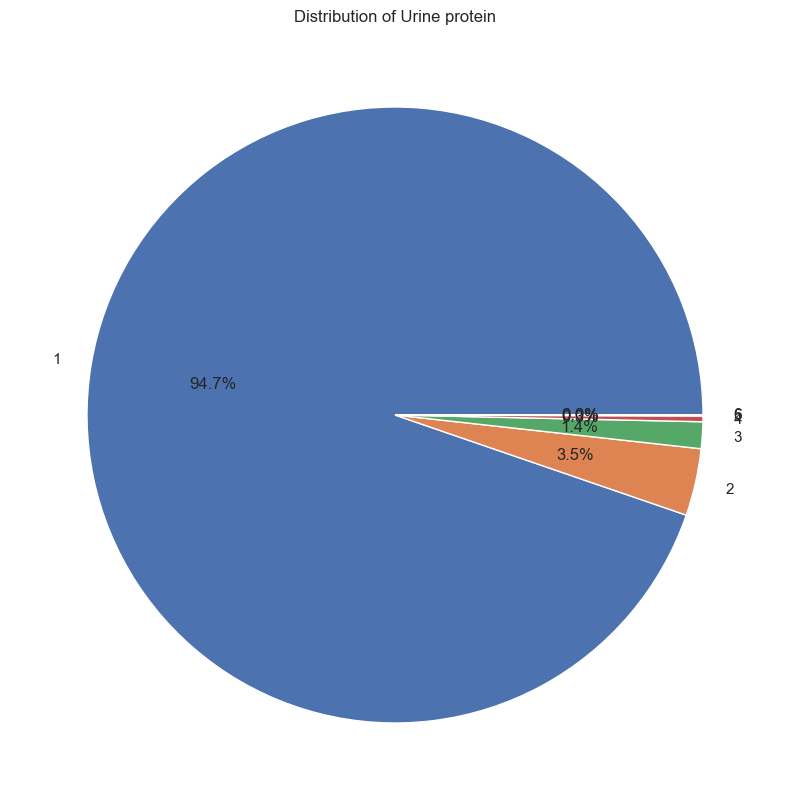

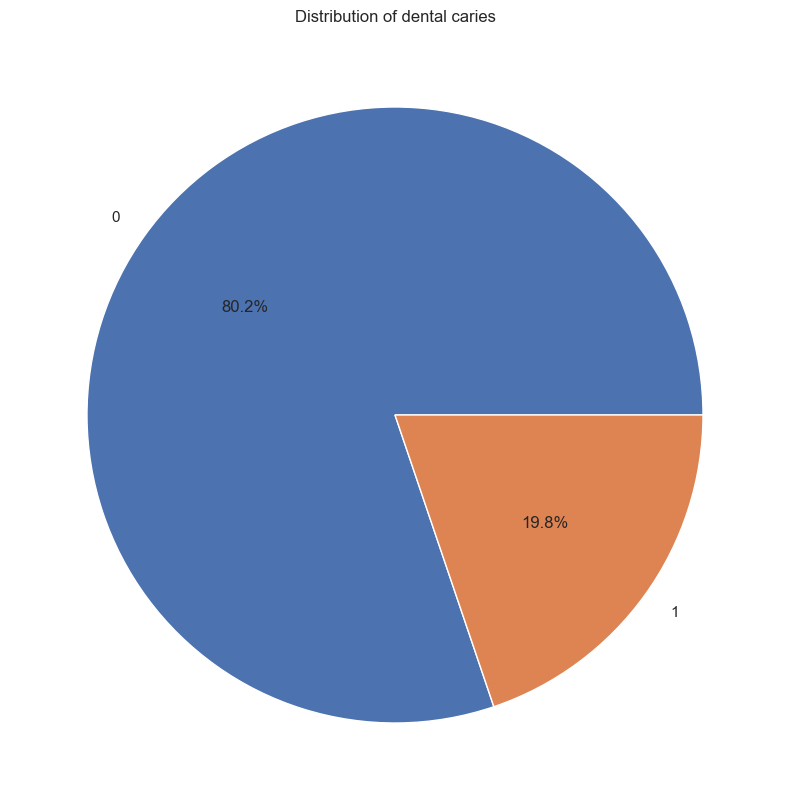

In [1397]:
for col in categorical_variables:
    do_pie(df, col)

#### Plotting the Categorical Variable target representations

The below cell takes all our categorical variables and plots their distributions with respect to ```smoking```. From here, we are able to make a few observations:
* Those with value **1** for ```hearing (left)``` tended to be mirror the general population, while those with value **2** ```left hearing``` had var fewer smokers.
* Similar as above can be observed for ```hearing (right)```.
* There were far fewer smokers (to similar degrees) for those who exibit ```urine proteins``` **2 thorugh 5**. There are no smokers for those who exibit ```urine protein``` **6**.
* There are notably more smokers for those with ```dental caries```, whereas those without ```dental caries``` tended to follow the patterns of the general population.

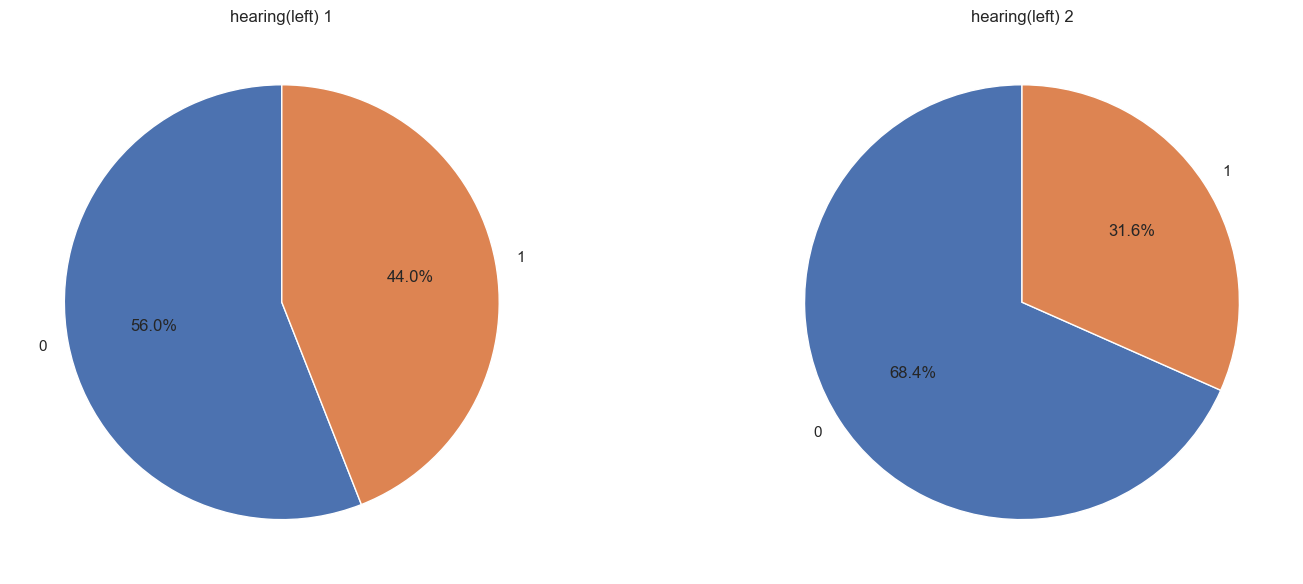

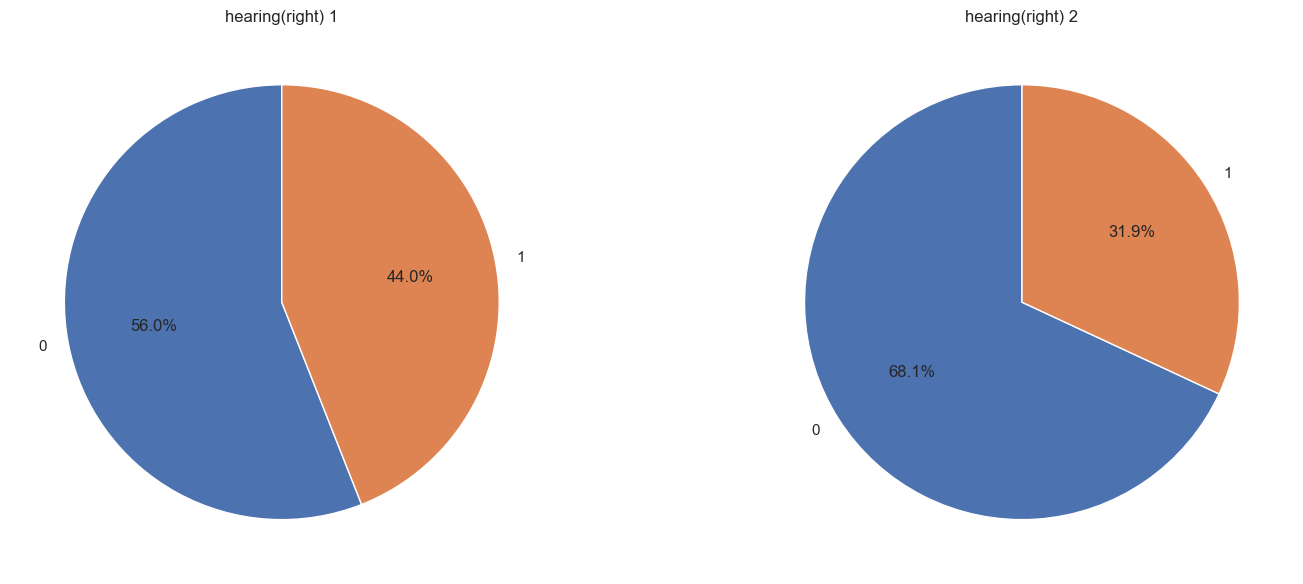

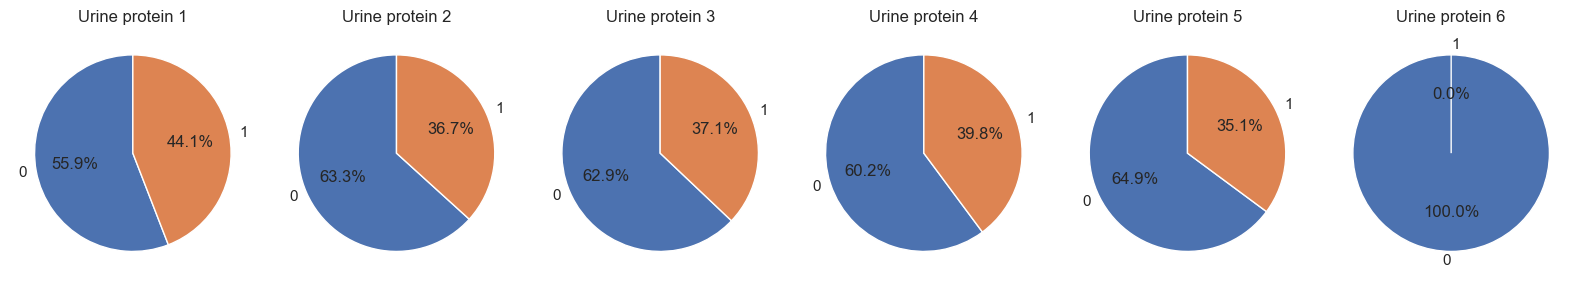

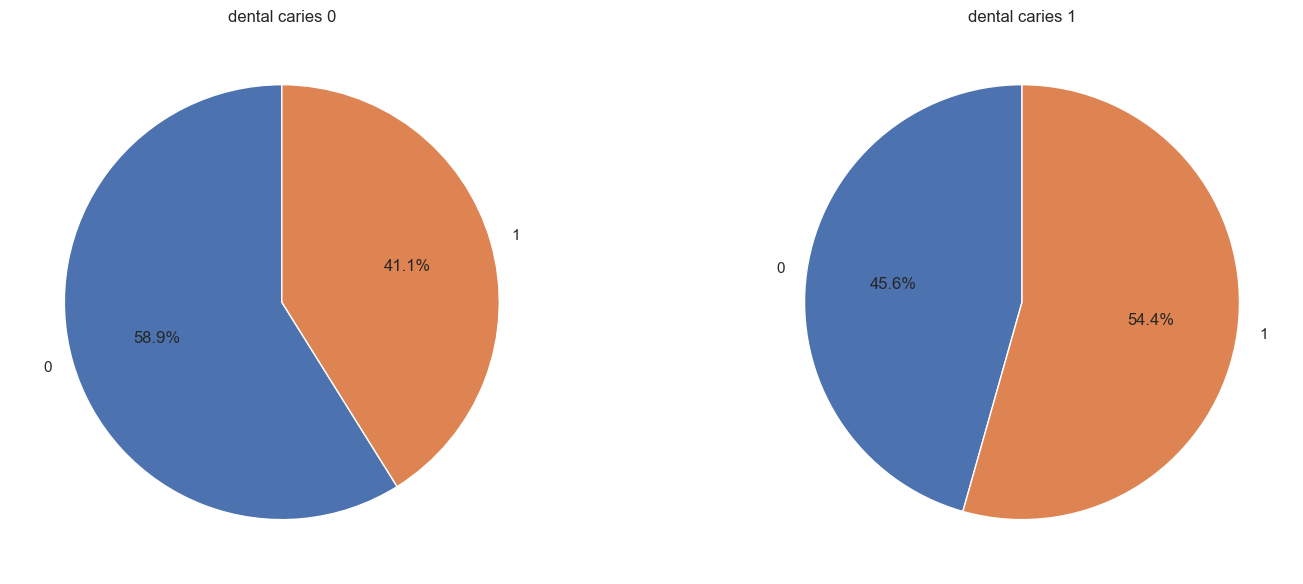

In [1398]:
for col in categorical_variables:
    plot_target_representation(df, col, target)

### Continuous Variable Examination 📈

We are able to make some observations based on the continuous variables:
* Most smokers tend to be a little younger in ```age```. After **45 years old**, there is a slight majority leaning non-smokers.
* Most smokers tend to be a little taller in ```height```. The vast majority of those under **165cm** are non-smokers, and there are notable majorities of smokers taller than **165cm**. We note that one's height may not directly correlate to whether or not they smoke. This variable is very nicely following a normal distribution.
* The ```weight``` is fairly normally-distributed with a slight left skew. Most non-smokers tend to be about **10kg** lighter, which is a bit surprising given that smoking surpresses appetite.
* The ```waist``` circumference follows a beautiful normal distribution. Most non-smokers tend to have a waist size of **2-5cm** less then their smoking counterparts, which seems to follow the patterns of weight (and that waist size tends to have a high correlation with weight).
* The ```eyesights``` do not visibly show any valuable correlations. The distribution of those with eyesights categorized > **2** are **very** imbalanced. There are about 130 people who are entirely blind in either/both of their eyes which will need to be brought into consideration.
* ```Systolic``` blood pressure seems quite normally distributed and we cannot see any clear trends with the target variable from just this. There are a few outliers that may need to be considered on this variable.
* The ```relaxed``` blood pressure follows a normal distribution, with smokers tending to exhibit a **higher relaxed blood pressure**.
* Non-smokers tend to have a slightly lower ```fasting blood sugar``` level. This variable exhibits many outliers that will need to be dealt with.
* ```Cholesterol``` follows a really nice normal distribution. Smokers may have a very slightly lower cholesterol reading than non-smokers, but it is so marginal that this observation will need further testing.
* There is a notable right-skew in the distribution of ```tryglycerides```. Smokers tend to have notably higher trygliceride levels.
* ```HDL``` levels of cholesterol tend to be notably lower for smokers. The distribution of ```HDL``` has a slight right skew.
* ```LDL``` cholesterol levels have many dispersed high outliers. We cannot make any observations about the target variable from the current chart.
* Smokers tend to have notably higher ```hemoglobin``` levels. The variable follows a nice, normal distribution.
* Smokers tend to have higher levels of ```serum creatinine``` than non-smokers. The variable also has many sparsely-distributed high-valued outliers that will need to be addressed.
* ```AST``` has many sparsely-distributed high-value outliers. Not much can be gleaned from it currently.
* ```ALT``` has the same to be said currently as AST.
* ```GTP``` exibits a severe right skew in its distribution. Smokers tend to have higher values for ```GTP``` than non-smokers. 

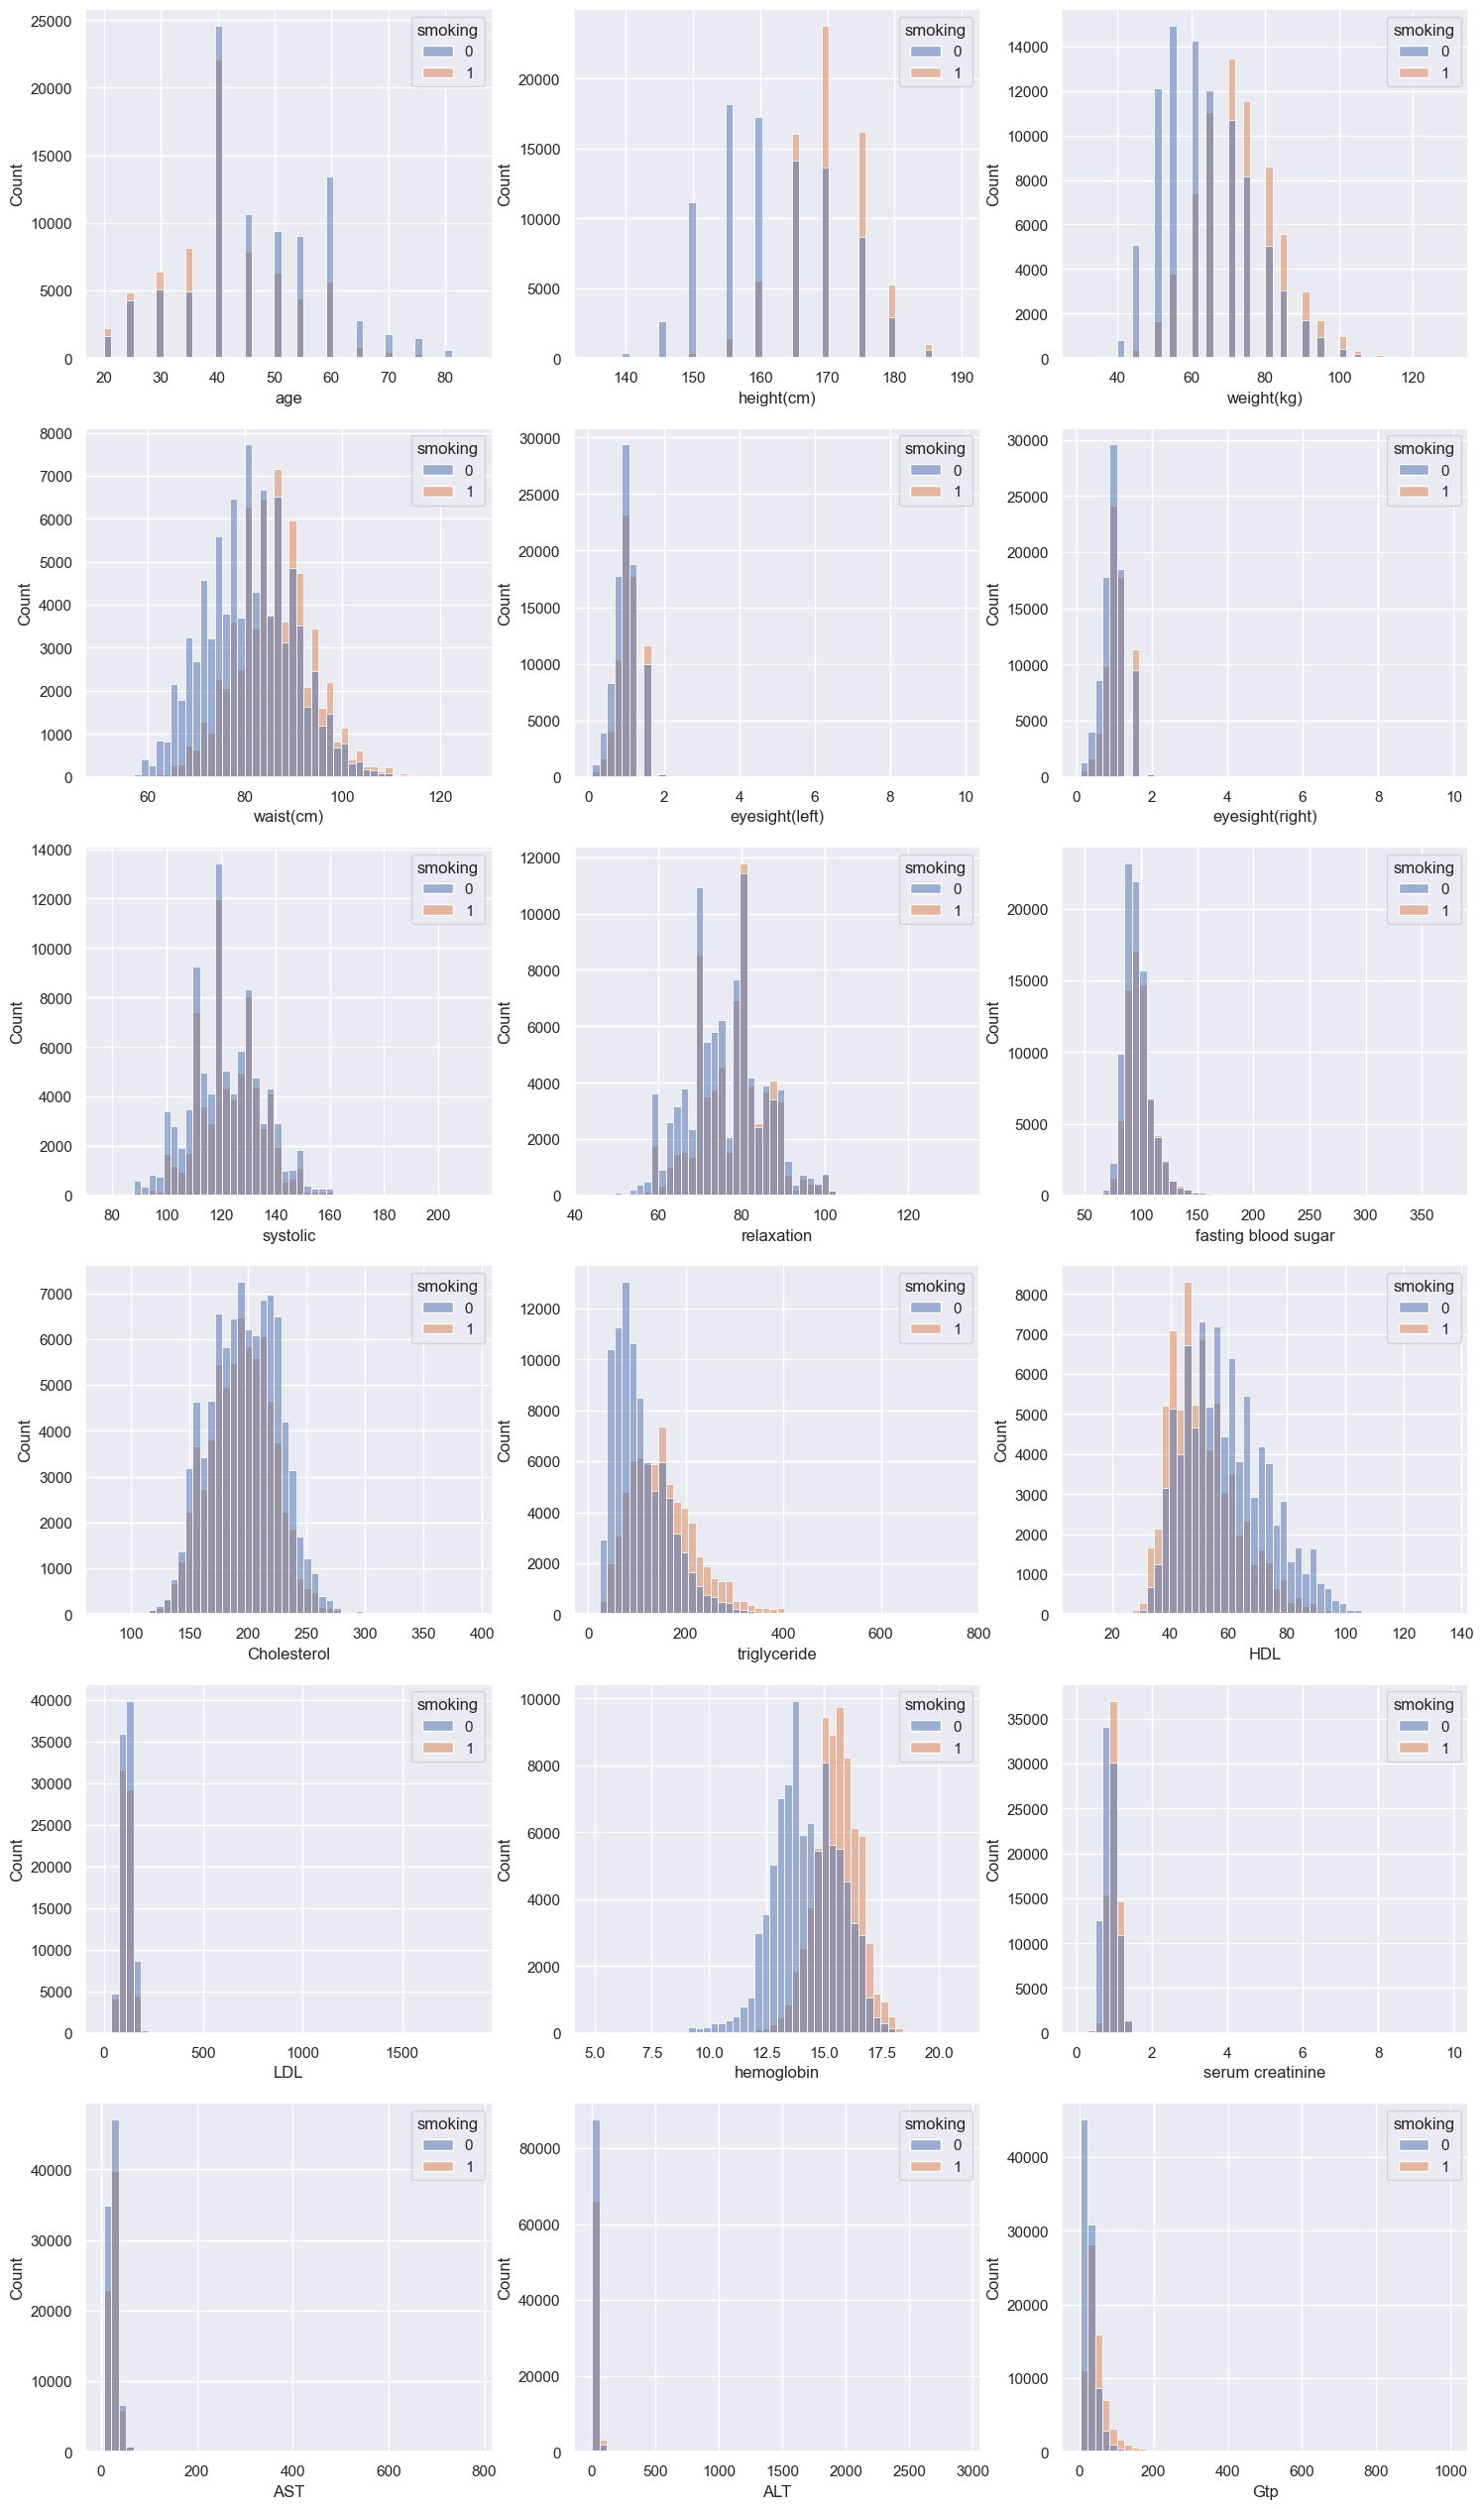

In [1399]:
# We aren't interested in analyzing ID since it will be meaningless
numerical_variables.remove('id')

_, axes = plt.subplots(nrows= 6, ncols=3, figsize=(18,32))
for feat, ax in zip(numerical_variables, axes.ravel()):
    if df[feat].dtype == 'object':
        sns.countplot(data=df, x=feat, ax=ax, hue=target)
    else:
        sns.histplot(data=df, x=feat, bins=50, ax=ax, hue=target)
plt.show()

### Correlation Matrix 

The correlation matrix output from the below snippet gives us some observations of interest:
* High has a notable negative correlation with ```age``` and positive correlation ```weight```. This makes sense given that once growth peaks in early 20's (the min ```age``` value), people can only get smaller. Likewise, taller people have to have mass to occupy their additional vertical space.
* ```Waist``` exibits a very high correlation with ```weight```, which also makes sense. This shared dimensionality may later need to be targeted, perhaps through feature engineering. It also has a notable positive correlation with ```height```.
* ```eyesight``` for both left and right tend to not correlate strongly with any other variable aside from eachother (which makes sense).
* ```hearing```: same can be said here as for eyesight.
* ```Systolic``` blood pressure has a very high correlation with ```resting heart rate```. It also exibits some slight positive correlations with ```hemoglobin```, ```gtp```, ```fasting blood sugar```, and ```tryglicerides```.
* ```Cholesterol``` has notable correlations with ```HDL```, ```LDL```, and ```tryglicerides``` (which makes sense given the nature of Cholesterol readings).
* ```AST``` and ```ALT``` exibit high correlations.

In general, high-level of domain understanding will be required for this work as it seems that the high correlations between variables will lead to bias in models, and feature engineering or SOME form of dimensionality reduction will need to be done with these variables.

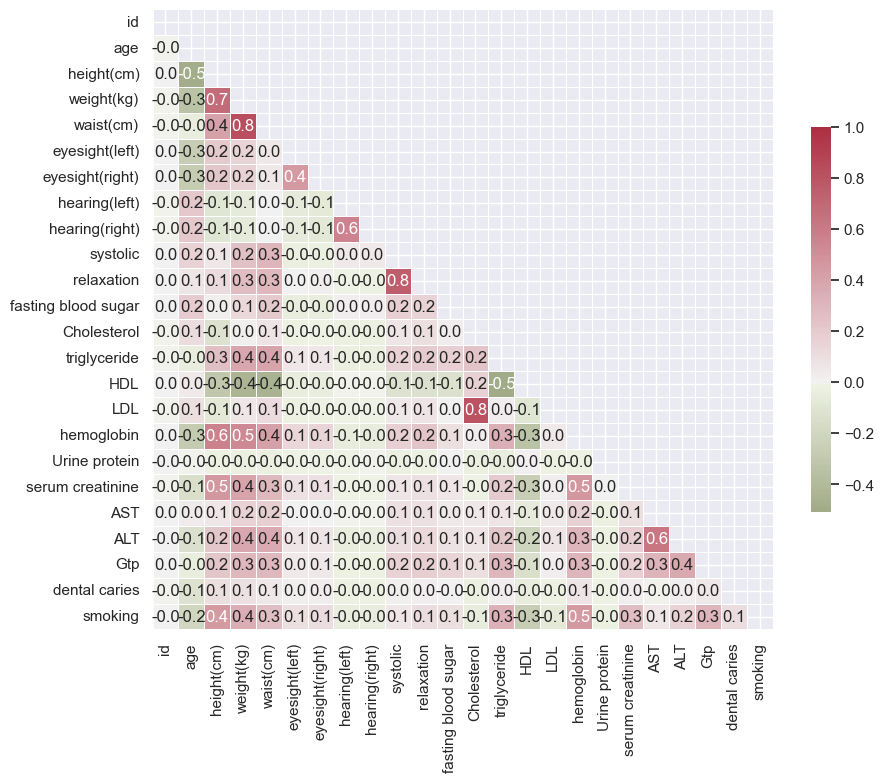

In [1400]:
sns.set(rc={'figure.figsize':(10,10)})

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5}, annot=True, fmt='.1f')
plt.show()

## Data Cleaning ✨ 

### Removing Useless Columns

The below cell declares an array of columns to remove from the dataframe. This will include columns like ```id``` which hold no value. It will also drop columns that are incorporated into features later as well.

In [1401]:
columns_to_remove = ['id']

### Outliers

There are several variables that have outliers which will need to be dealt with.

No differences in performance have been noted when testing mean outliers vs. the data simply scaled with the outliers left in.

In [1402]:
"""Sets outliers (3 zscores outside) to mean"""
def outliers_to_mean(df_initial, cols):
    df = df_initial.copy()
    for col in cols:
        z_scores = stats.zscore(df[col])
        non_outliers = abs(z_scores) <=3
        mean_value = df.loc[non_outliers, col].mean()
        df.loc[abs(z_scores) > 3, col] = mean_value
    return df

# Declare array of columns to deal with
outlier_columns = ['eyesight(left)', 'eyesight(right)', 'serum creatinine', 'LDL', 'AST', 'ALT', 'Gtp', 'triglyceride', 'fasting blood sugar']

### Noting Skewed Features

The below cell defines an array of columns with right and left-skews to preprocess.

In [1403]:
left_skew_features = ['eyesight(left)', 'eyesight(right)', 'hemoglobin']
right_skew_features = ['AST', 'ALT', 'Gtp', 'triglyceride', 'HDL']

In [1404]:
"""Normalizes features by square root for left skews and log for right skews"""
def normalize_skews(df_in, left_s, right_s):
    df = df_in.copy()
    for col in left_s:
        df[col] = np.sqrt(df[col])
    for col in right_s:
        df[col] = np.log1p(df[col])
    return df

### Scaling Features

The baseline performance was evaluated with a ```Standard Scaler```.
Working with a ```MinMax Scaler``` resulted in no differences in performance.

In [1405]:
# Initialize the StandardScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

### One Hot Encoding

In [1406]:
# Helper function to encode a variable
def encode(df, cols):
    new_categories = []
    for col in cols:
        if col in df.columns:
            #         one_hot_encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
            one_hot_encoded = pd.get_dummies(df[col], prefix=col)
            for new_col in one_hot_encoded.columns:
                new_categories.append(new_col)
            df = pd.concat([df, one_hot_encoded], axis=1)
            if not (col == target):
                df = df.drop([col], axis = 1)
    return df, new_categories

### Feature Engineering

#### Cholesterol Ratio 

The ```Cholesterol Ratio``` is calculated as the ratio of ```LDL``` ("Bad Cholesterol") to ```HDL``` ("Good Cholesterol"). This reduces shared dimensionality in the underlying data while remaining a useful indicateor for smoking given that smoking can both increase the ```LDL``` levels while reducing the ```HDL``` levels.

In [1407]:
# Flag whether to include this feature
add_cholesterol_ratio = True

def create_cholesterol_ratio(df_input):
    df = df_input.copy()
    df['cholesterol_ratio'] = df['LDL']/df['HDL']
    return df

if add_cholesterol_ratio == True:
    numerical_variables.append('cholesterol_ratio')

### Bad Cholesterol

We will define ```bad_cholesterol``` as the total cholesterol levels minus the ```HDL``` levels. Then this will allow us to remove the ```Cholesterol``` and ```LDL``` variables.

In [1408]:
add_bad_cholesterol = True

def create_bad_cholesterol(df_input):
    df = df_input.copy()
    df['bad_cholesterol'] = df['Cholesterol'] - df['HDL']
    return df

if add_bad_cholesterol == True:
    numerical_variables.append('bad_cholesterol')

### Hearing

In [1409]:
add_bad_hearing = True

df['hearing(left)'] = df['hearing(left)'].replace({1:0, 2:1})
df['hearing(right)'] = df['hearing(right)'].replace({1:0, 2:1})

def create_bad_hearing(df_input):
    df = df_input.copy()
    print(df.columns)
    df['hearing_bad'] = ((df['hearing(left)'] == 1) & (df['hearing(right)'] ==1))
    return df

if add_bad_hearing == True:
    categorical_variables.append('hearing_bad')

## Full Data Pipeline 

In [1410]:
def cleaning_pipeline(df):
    df_clean = df.copy()

    if add_bad_hearing == True:
        df_clean = create_bad_hearing(df_clean)
        if 'hearing(left)' in categorical_variables: categorical_variables.remove('hearing(left)')
        if 'hearing(right)' in categorical_variables: categorical_variables.remove('hearing(right)')

    df_clean, idc = encode(df_clean, categorical_variables)

    # Add features
    if add_cholesterol_ratio == True:
        df_clean = create_cholesterol_ratio(df_clean)
        if 'HDL' in numerical_variables: numerical_variables.remove('HDL')
        if 'LDL' in numerical_variables: numerical_variables.remove('LDL')
    if add_bad_cholesterol == True:
        df_clean = create_bad_cholesterol(df_clean)
        if 'HDL' in numerical_variables: numerical_variables.remove('HDL')
        if 'Cholesterol' in numerical_variables: numerical_variables.remove('Cholesterol')

    # Sets desired outliers to mean
    df_clean = outliers_to_mean(df_clean, outlier_columns)
    
    # Normalizes skews
    df_clean = normalize_skews(df_clean, left_skew_features, right_skew_features)

    # Scale numerical columns
    df_clean[numerical_variables] = scaler.fit_transform(df_clean[numerical_variables])

    # Drop columns to remove
    df_clean = df_clean.drop(columns_to_remove, axis=1)
    return df_clean, idc

In [1411]:
df_clean, categorical_variables = cleaning_pipeline(df)

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')


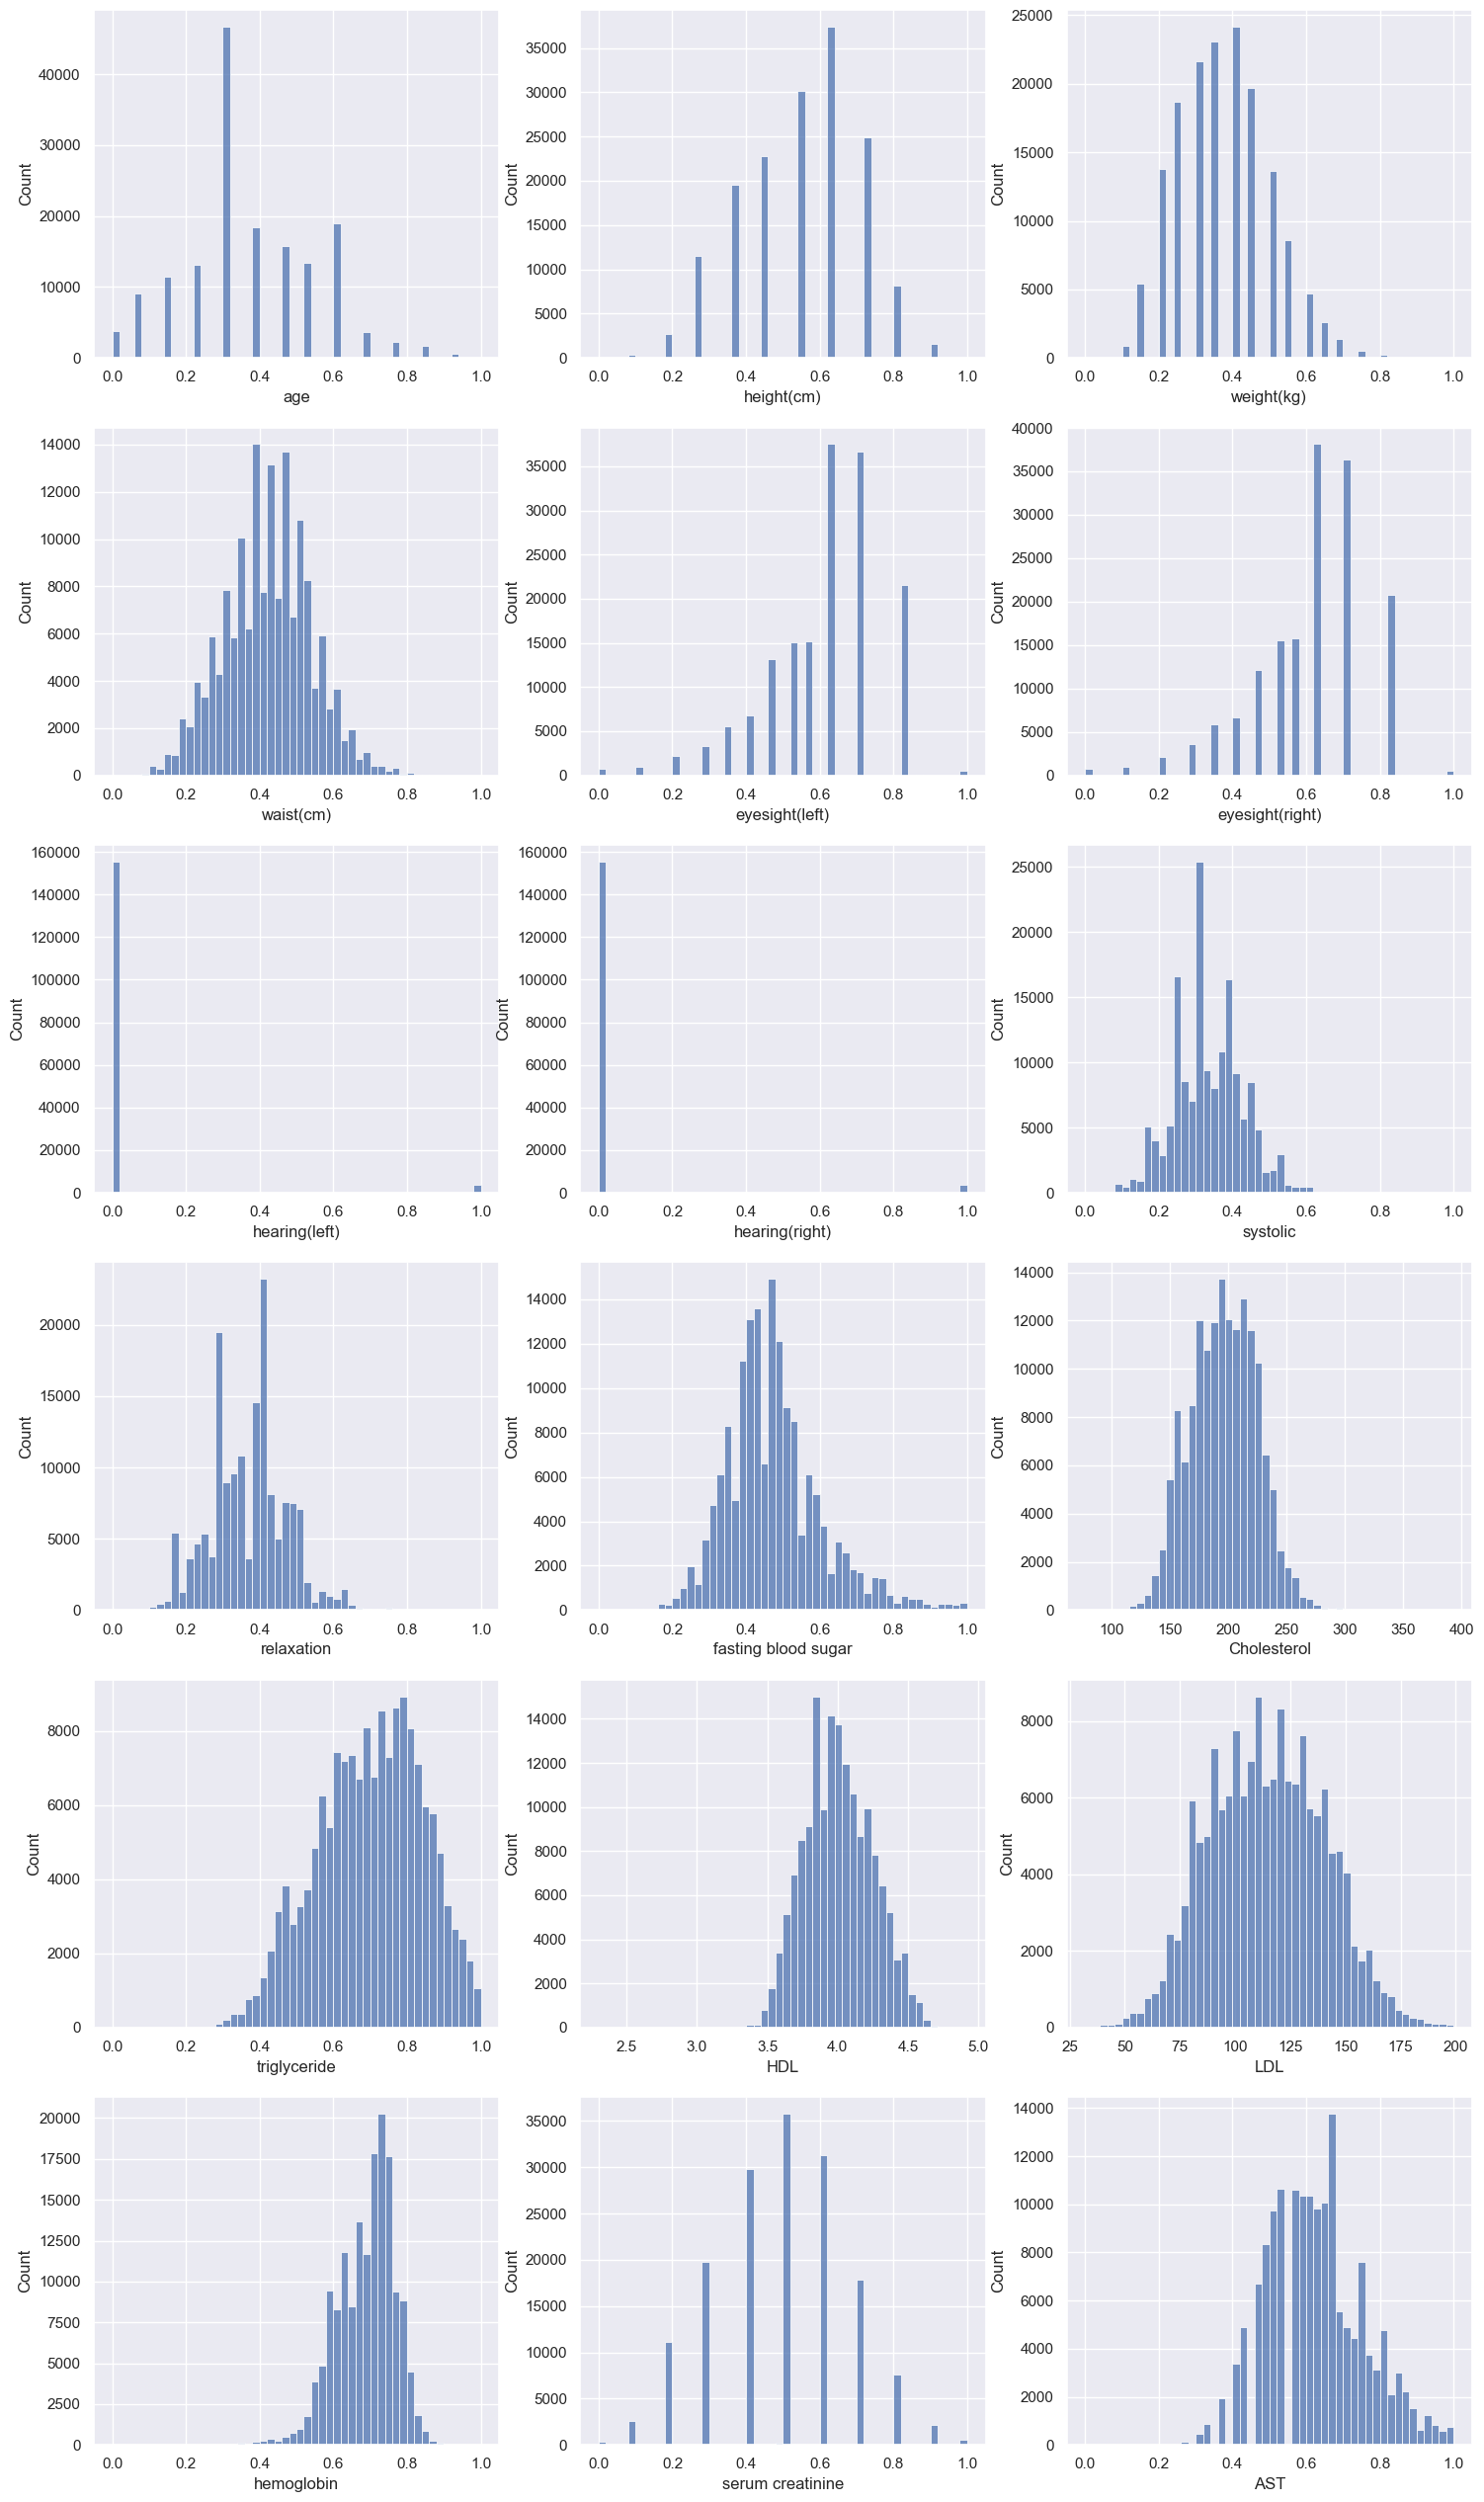

In [1412]:
_, axes = plt.subplots(nrows= 6, ncols=3, figsize=(18,32))
for feat, ax in zip(df_clean.columns, axes.ravel()):
    if df_clean[feat].dtype == 'object':
        # sns.countplot(data=df_clean, x=feat, ax=ax, hue=target)
        sns.countplot(data=df_clean, x=feat, ax=ax)
    else:
        sns.histplot(data=df_clean, x=feat, bins=50, ax=ax)
plt.show()

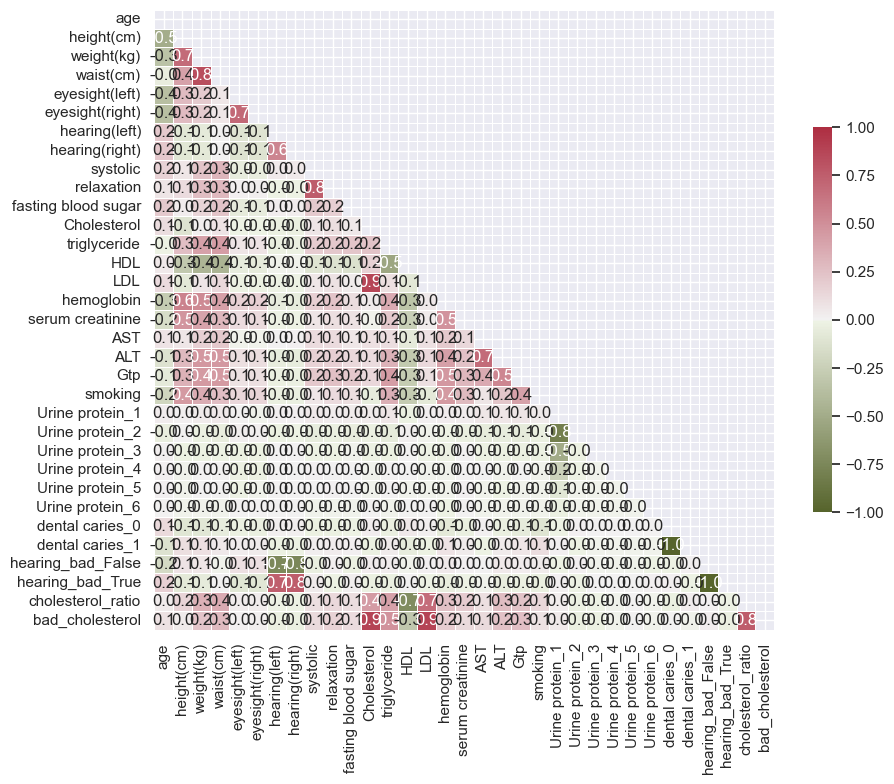

In [1413]:
sns.set(rc={'figure.figsize':(10,10)})

corr = df_clean.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5}, annot=True, fmt='.1f')
plt.show()

## Splitting 🖖

In [1414]:
features = [
'age', 
'height(cm)',
'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar',
       'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'hearing(left)_1',
       'hearing(right)_1',
       'Urine protein_1', 'Urine protein_2', 'Urine protein_3',
       'Urine protein_4', 'Urine protein_5', 'Urine protein_6',
       'dental caries_0',
]

for col in numerical_variables:
    if col not in df_clean.columns:
        numerical_variables.remove(col)
for col in categorical_variables:
    if col not in df_clean.columns:
        categorical_variables.remove(col)

features = numerical_variables + categorical_variables

# if add_cholesterol_ratio == True:
#     features.remove('LDL')
#     features.remove('HDL')
#     features.append('cholesterol_ratio')

# X_train, X_test, y_train, y_test = train_test_split(df_clean[features], df_clean[target], test_size=0.2, random_state=random_seed)
X_train = df_clean[features]
y_train = df_clean[target]
features

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'triglyceride',
 'hemoglobin',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'cholesterol_ratio',
 'bad_cholesterol',
 'Urine protein_1',
 'Urine protein_2',
 'Urine protein_3',
 'Urine protein_4',
 'Urine protein_5',
 'Urine protein_6',
 'dental caries_0',
 'dental caries_1',
 'hearing_bad_False',
 'hearing_bad_True']

## Machine Learning 🤖

### Decision Tree Classifier 🌳

Decision Tree Classifiers are one of the most simple models to implement while retaining explainability and are especially useful in initial iterations of the machine learning pipeline

In [1415]:
# Create and train a Decision Tree Classifier
classifier = DecisionTreeClassifier(max_depth=8)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

<table>
    <tr><th>Description</th><th>weighted-avg f1-score</th></tr>
    <tr><th>Baseline</th><th>.75</th></tr>
    <tr><th>Max-Depth: 8</th><th>.76</th></tr>
    <tr><th>Max-Depth: 10</th><th>.76</th></tr>
    <tr><th>Max-Depth: 12</th><th>.75</th></tr>
    <tr><th>Max-Depth: 15</th><th>.73</th></tr>
</table>

In [1416]:
# Predict using the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77     17783
           1       0.69      0.85      0.76     14069

    accuracy                           0.76     31852
   macro avg       0.77      0.77      0.76     31852
weighted avg       0.78      0.76      0.76     31852



#### Get Feature Importances

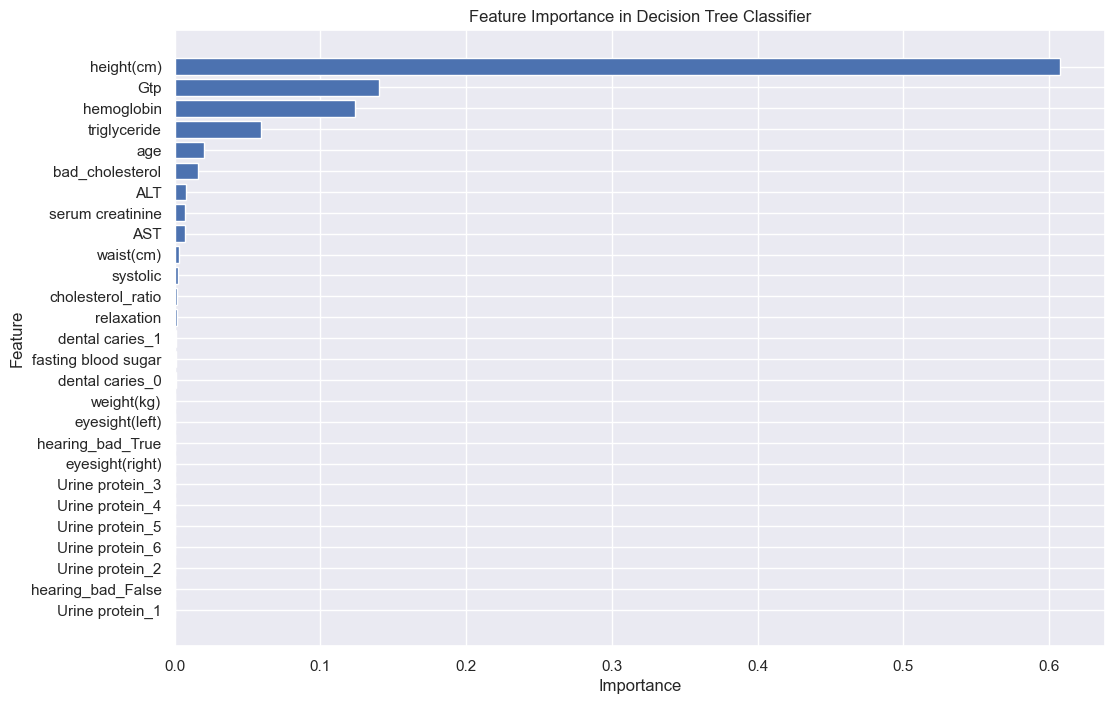

In [1417]:
importances = classifier.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Classifier')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

### Random Forest Classifier 🦚🦚

In [1418]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Making & Evaluating Predictions

<table>
    <tr><th>Description</th><th>weighted-avg f1-score</th></tr>
    <tr><th>Baseline</th><th style="background: yellow; color: black; font-weight: bolder">0.77</th></tr>
    <tr><th>No skew or outlier cleaning</th><th>.0.77</th></tr>

</table>

In [1419]:
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy: .2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy:  1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17783
           1       1.00      1.00      1.00     14069

    accuracy                           1.00     31852
   macro avg       1.00      1.00      1.00     31852
weighted avg       1.00      1.00      1.00     31852



#### Hyperparameter Tuning

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.7771733991843093
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

In [1420]:
param_grid = {
    'n_estimators': [100, 200, 300],
    # 'max_features': ['auto', 'sqrt'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

perform_rfc_tuning = False

if perform_rfc_tuning:
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

### XGBoost 📉

#### Initialize and fit the XGBoost Model

In [1421]:
# #XGBoost parameters
xgb_params =  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 400, 'subsample': 1.0}

xgb_model = XGBClassifier(**xgb_params )
# xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Predict and Evaluate the Model

<table>
    <tr><th>Description</th><th>F1-score weighted avg</th></tr>
    <tr><th>Baseline</th><th>.0.78</th></tr>
    <tr><th>No skew or outlier cleaning</th><th>.0.78</th></tr>
    <tr><th>Added Cholesterol Features</th><th>.0.78</th></tr>
    <tr><th>Added Bad Hearing Feature</th><th>.0.78</th></tr>
</table>

In [1422]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81     17783
           1       0.75      0.83      0.79     14069

    accuracy                           0.80     31852
   macro avg       0.80      0.80      0.80     31852
weighted avg       0.81      0.80      0.80     31852



#### Hyperparameter Tuning

The best hyperparameters found are {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 400, 'subsample': 1.0}

In [1423]:
param_grid = {
    'n_estimators': [ 200, 300, 400],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [2, 4, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

perform_xgb_tuning = False

if perform_xgb_tuning == True:
    model = xgb.XGBClassifier()
    grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)
else:
    print("Hyperparameter tuning skipped.")

Hyperparameter tuning skipped.


#### Plot Feature Importances 🏆

Our baseline model ranks the most important features as:
```trygliceride```, ```Gtp```, ```LDL```, ```Cholesterol```, ```Hemoglobin```, ```fasting blood sugar```, ```ALT```, ```waist```, ```HDL```, ```systolic```.

There is quite a lot of shared dimensionality between these as 4 of them are cholesterol related and 2 of them are blood pressure related. Feature engineering will be necessary to improve these.

<Figure size 1000x800 with 0 Axes>

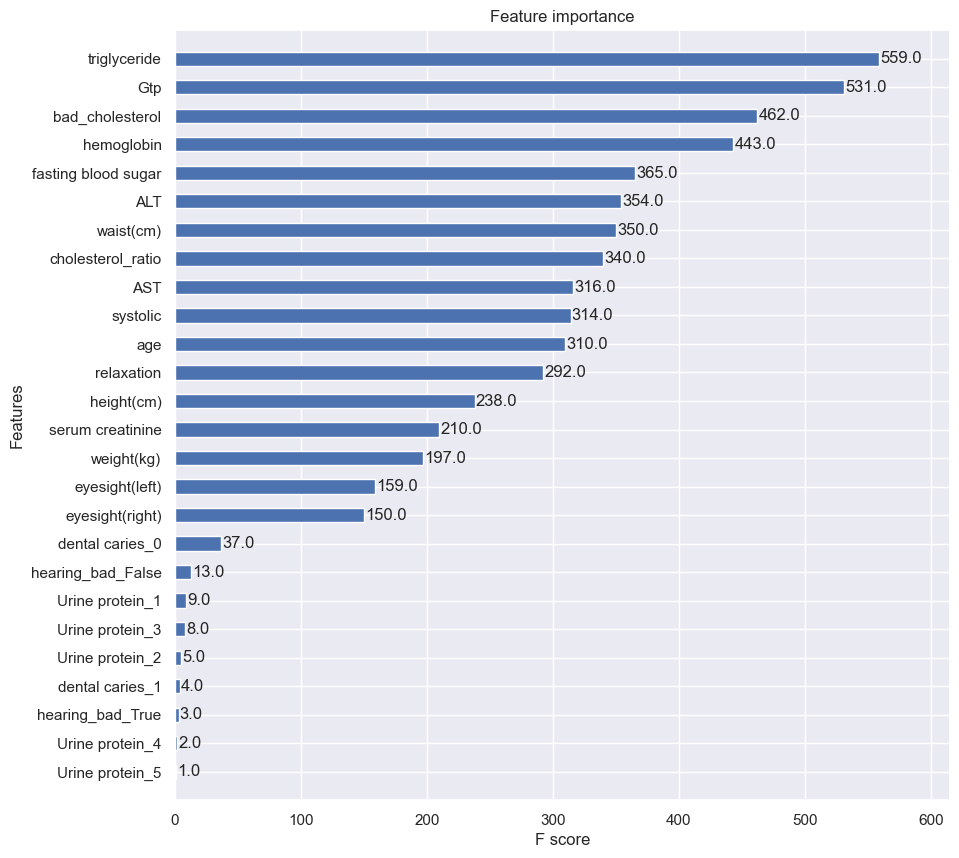

In [1424]:
from xgboost import plot_importance

# Plot feature importances
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, height=0.5)
plt.show()

In [1425]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print(f'ROC AUC Score: {roc_auc}')

ROC AUC Score: 0.8045377205931578


### Neural Network 🧠

#### Create and Fit the Network

* baseline: loss: 0.4591 - accuracy: 0.7714 - val_loss: 0.4598 - val_accuracy: <span style="background-color: yellow; font-weight: bolder; color: black">0.7739</span>
* added layer of 64 rely - loss: 0.4617 - accuracy: 0.7702 - val_loss: 0.4550 - val_accuracy: 0.7736
* batch normalization - loss: 0.4927 - accuracy: 0.7603 - val_loss: 0.4767 - val_accuracy: 0.7728
* feature added: cholesterol ratio - loss: 0.4667 - accuracy: 0.7688 - val_loss: 0.4615 - val_accuracy: 0.7716

In [1426]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers.legacy import Adam # Use the old one for local training on my M2 Mac
from keras.layers import Dense, Dropout, BatchNormalization

y = y_train.astype('float32')
X = X_train.astype('float32')

# Create a neural network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

# Batch normalization
# nn_model = Sequential()
# nn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# nn_model.add(BatchNormalization())
# nn_model.add(Dropout(0.5))
# nn_model.add(Dense(64, activation='relu'))
# nn_model.add(BatchNormalization())
# nn_model.add(Dropout(0.5))
# nn_model.add(Dense(32, activation='relu'))
# nn_model.add(BatchNormalization())
# nn_model.add(Dense(1, activation='linear'))

# nn_model = Sequential()
# nn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# nn_model.add(Dense(64, activation='relu'))
# # nn_model.add(Dense(32, activation='relu'))
# nn_model.add(Dense(1, activation='linear'))

# Compile the model
nn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Fit the model
history = nn_model.fit(X, y, epochs=35, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/35
3982/3982 [==============================] - 2s 496us/step - loss: 0.5827 - accuracy: 0.7171 - val_loss: 0.5180 - val_accuracy: 0.7465
Epoch 2/35
3982/3982 [==============================] - 2s 516us/step - loss: 0.5253 - accuracy: 0.7416 - val_loss: 0.5175 - val_accuracy: 0.7533
Epoch 3/35
3982/3982 [==============================] - 2s 476us/step - loss: 0.5387 - accuracy: 0.7335 - val_loss: 0.5113 - val_accuracy: 0.7517
Epoch 4/35
3982/3982 [==============================] - 2s 474us/step - loss: 0.5227 - accuracy: 0.7464 - val_loss: 0.5086 - val_accuracy: 0.7541
Epoch 5/35
3982/3982 [==============================] - 2s 476us/step - loss: 0.5227 - accuracy: 0.7452 - val_loss: 0.5029 - val_accuracy: 0.7567
Epoch 6/35
3982/3982 [==============================] - 2s 477us/step - loss: 0.5146 - accuracy: 0.7486 - val_loss: 0.4996 - val_accuracy: 0.7596
Epoch 7/35
3982/3982 [==============================] - 2s 475us/step - loss: 0.5201 - accuracy: 0.7487 - val_loss: 0.5065 -

#### Observe the Training Graphs

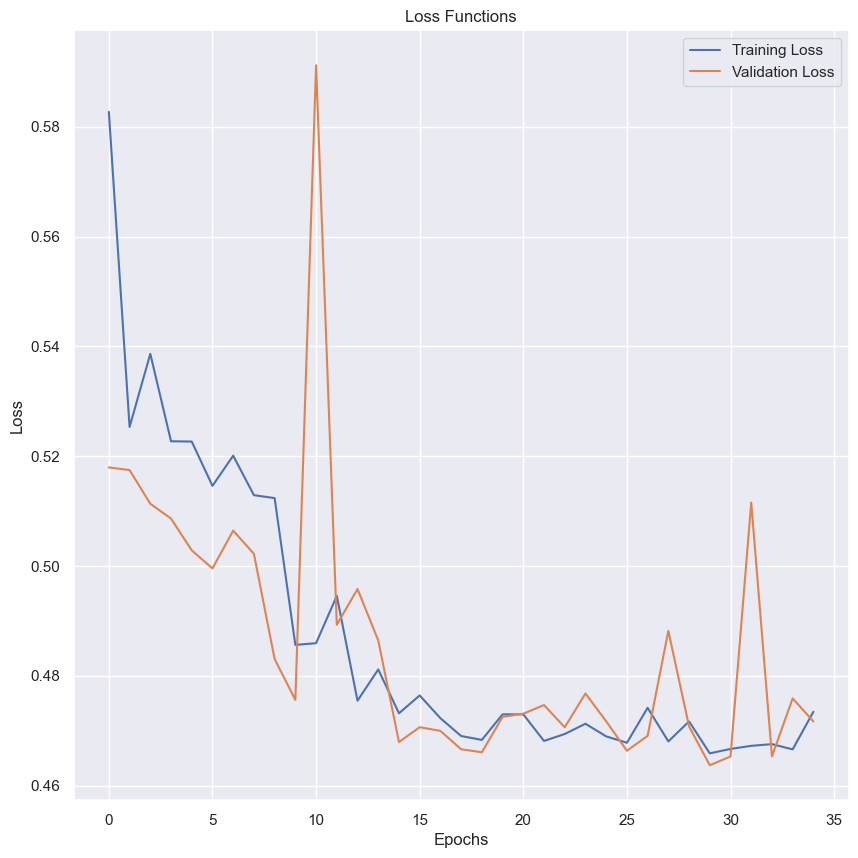

In [1427]:
# Access loss and accuracy history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the loss over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Functions")
plt.show()

#### Make & Evaluate Predictions

In [1428]:
y_pred = model.predict(X_test.astype('float32'))
# print(classification_report(y_test, y_pred))
y_pred

InvalidArgumentError: Graph execution error:

Detected at node sequential_16/dense_48/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Users/ianfeekes/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/4f/6c2p53ln64s21k6dzcxg0hj00000gn/T/ipykernel_99111/1484405720.py", line 1, in <module>

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2631, in predict

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py", line 5397, in relu

Matrix size-incompatible: In[0]: [32,27], In[1]: [30,64]
	 [[{{node sequential_16/dense_48/Relu}}]] [Op:__inference_predict_function_17778643]

#### Hyperparameter Tuning

In [ ]:
from keras_tuner import HyperModel

tune_nn = False

if tune_nn == True:
    class MyHyperModel(HyperModel):
        def __init__(self, input_dim):
            self.input_dim = input_dim

        def build(self, hp):
            model = Sequential()
            model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                            activation='relu', input_dim=self.input_dim))
            model.add(Dense(1, activation='linear'))
            model.compile(optimizer='adam', loss='binary_crossentropy')
            return model

    from keras_tuner.tuners import RandomSearch

    tuner = RandomSearch(
        MyHyperModel(input_dim=X_train.shape[1]),
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=3,
        directory='nn_tuning',
        project_name='hparam_tuning'
    )

    tuner.search(X, y, epochs=15, validation_split=0.2)
    best_model = tuner.get_best_models(num_models=1)[0]
else:
    print("Tuning skipped.")

Tuning skipped.


## Submission ✅

In [1431]:
df_test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [1440]:
categorical_variables = []
numerical_variables = []

for col in df_test.columns:
    if len(df_test[col].value_counts().keys()) < 10:
        categorical_variables.append(col)
    else:
        numerical_variables.append(col)

if add_bad_hearing == True:
    categorical_variables.append('hearing_bad')

categorical_variables

['hearing(left)',
 'hearing(right)',
 'Urine protein',
 'dental caries',
 'hearing_bad']

In [1441]:
df_test_clean, _ = cleaning_pipeline(df_test)
df_test_clean = df_test_clean[features]

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')


In [1449]:
submission_pred = xgb_model.predict_proba(df_test_clean)
submission_pred[:, 1]

array([0.8461048 , 0.20239265, 0.17400727, ..., 0.37328225, 0.12373982,
       0.06317064], dtype=float32)

In [1447]:
df_sample_submission.head()

,id,smoking
0,159256,0.5
1,159257,0.5
2,159258,0.5
3,159259,0.5
4,159260,0.5


In [1453]:
submission_df = pd.DataFrame()
submission_df['id'] = df_test['id']
submission_df['smoking'] = submission_pred[:, -1]
submission_df.head()

,id,smoking
0,159256,0.846105
1,159257,0.202393
2,159258,0.174007
3,159259,0.290104
4,159260,0.685440


In [1454]:
submission_df.to_csv('./submission.csv')